In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import load, add_variables, clean_data
from src.preprocessing import DataSet
from src.forecast import NaiveDrift, NaiveLast, NaiveSeasonal, NaiveAVG, TSCV, OLS
from src.ploting import LinearPlot

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)

In [27]:
CURRENCY = "EURUSD"
INTERVAL = "15m"

## Podział na zbiory train, test, validate

In [28]:
eurusd = load(currency=CURRENCY, interval=INTERVAL)
data = DataSet(data=eurusd, ratios=[0.9, 0.1], label=['target_direction', 'target_value'])
train, val, test = data.add_variables().clean_data().normalize(how="standarize").get_tvt_df()

# Metody naiwne

In [34]:
eurusd = load(currency=CURRENCY, interval=INTERVAL)
eurusd = clean_data(eurusd)
data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=50,
            test_size=5)

In [40]:
results = {'sns': {}, 'avg': {}, 'drift': {}, 'last': {}}
tscv.run(model=NaiveSeasonal(), h=5, k=4, norm_type="standarize")
results['sns'] = tscv.metric_values
print("sns")

avg = tscv.run(model=NaiveAVG(), h=5, T=4, norm_type="standarize")
tscv.run(model=NaiveAVG(), h=5, T=4, norm_type="standarize")
results['avg'] = tscv.metric_values
print("avg")

drift = tscv.run(model=NaiveDrift(), h=5, norm_type="standarize")
tscv.run(model=NaiveDrift(), h=5, norm_type="standarize")
results['drift'] = tscv.metric_values
print("drift")

last = tscv.run(model=NaiveLast(), h=5, norm_type="standarize")
tscv.run(model=NaiveLast(), h=5, norm_type="standarize")
results['last'] = tscv.metric_values
print("last")

sns
avg
drift
last


<Axes: >

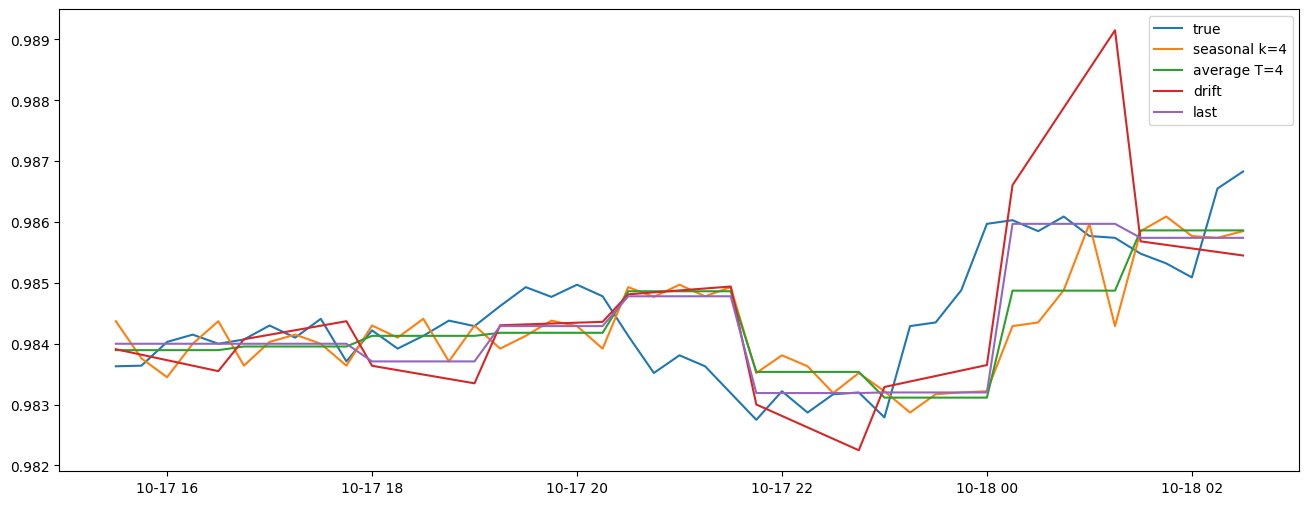

In [12]:
label = 'target_value'
train, test = tscv.dataset.train, tscv.dataset.test

x = tscv.dataset.data.index[-45:]

lp = LinearPlot(legend=True, h=6, w=16)
lp.plot(x, tscv.dataset.data.loc[x, label], label="true")
lp.plot(x, results['sns']['predicted'][:-5], label="seasonal k=4")
lp.plot(x, results['avg']['predicted'][:-5], label="average T=4")
lp.plot(x, results['drift']['predicted'][:-5], label="drift")
lp.plot(x, results['last']['predicted'][:-5], label="last")

# MNK

In [45]:
tscv.run(model=OLS())
results['ols'] = tscv.metric_values

In [47]:
pd.DataFrame().from_dict(results).transpose()

,mean_absolute_percentage_error,rmse
sns,0.000398,0.000465
avg,0.000313,0.000370
drift,0.000872,0.000947
last,0.000450,0.000554
ols,0.000352,0.000487


<Axes: >

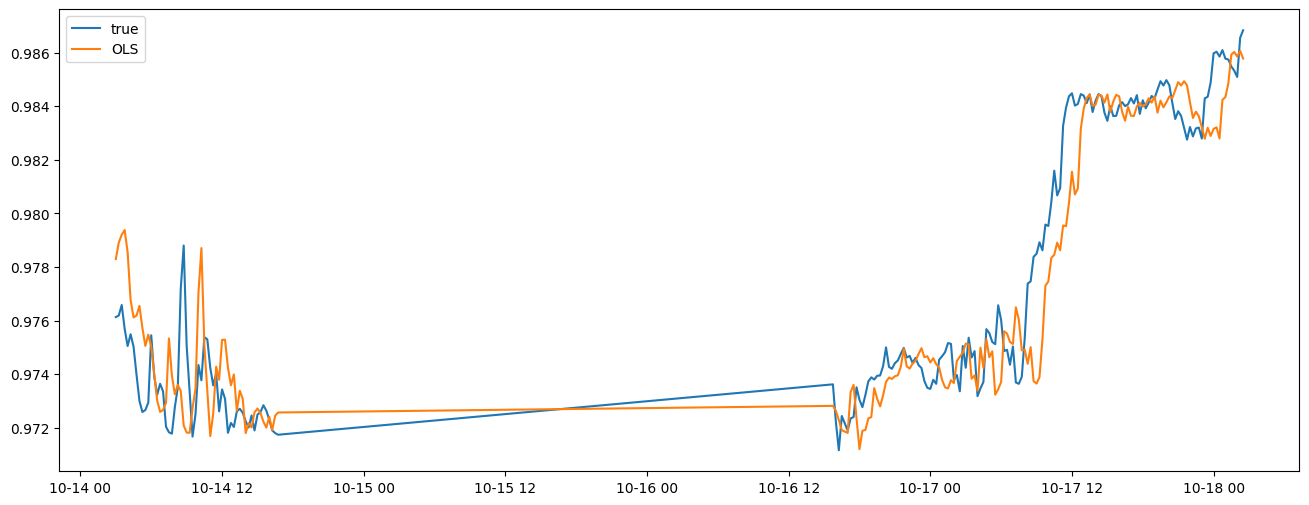

In [16]:
x = tscv.dataset.data.index[-195:]

lp = LinearPlot(legend=True, h=6, w=16)
lp.plot(x, tscv.dataset.data.loc[x, 'target_value'], label="true")
lp.plot(x, tscv.predicted[:-5], label="OLS")